In [35]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
import cv2
import matplotlib.pyplot as plt

print(tf.__version__)

2.7.0


In [36]:
# Download data
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [37]:
# Initialise model
input_shape = (28, 28, 1)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu', input_shape=input_shape),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'), # conv2d_3
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10),
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 3136)              0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, 
                    validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1342 - accuracy: 0.9586 - val_loss: 0.0453 - val_accuracy: 0.9849
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0438 - accuracy: 0.9862 - val_loss: 0.0416 - val_accuracy: 0.9862
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0299 - accuracy: 0.9906 - val_loss: 0.0287 - val_accuracy: 0.9901
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0230 - accuracy: 0.9926 - val_loss: 0.0275 - val_accuracy: 0.9912
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0166 - accuracy: 0.9943 - val_loss: 0.0265 - val_accuracy: 0.9919
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0127 - accuracy: 0.9960 - val_loss: 0.0296 - val_accuracy: 0.9915
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0100 - accuracy: 0.9966 - val_loss: 0.0261 - val_accuracy:

In [39]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [40]:
y_hats = model.predict(x_test)
mistakes = np.where(y_test != np.argmax(y_hats, axis=1))[0]

Predicted: 7


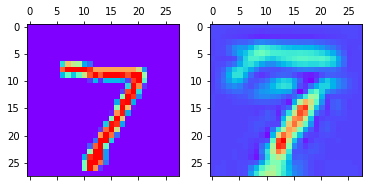

Predicted: 2


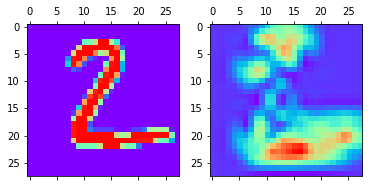

Predicted: 1


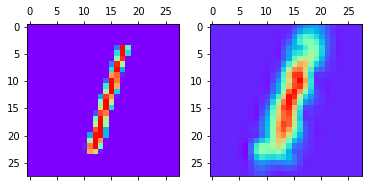

Predicted: 0


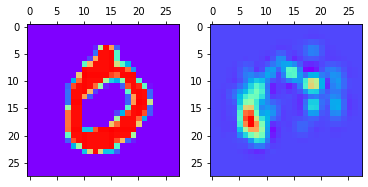

Predicted: 4


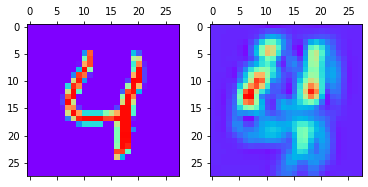

Predicted: 1


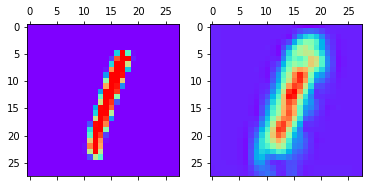

Predicted: 4


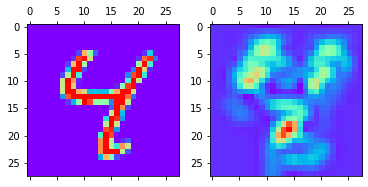

Predicted: 9


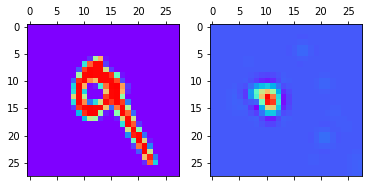

Predicted: 5


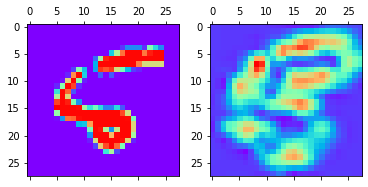

Predicted: 9


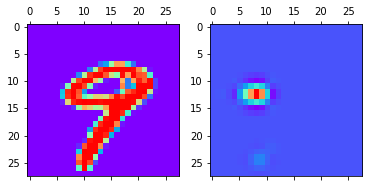

Predicted: 0


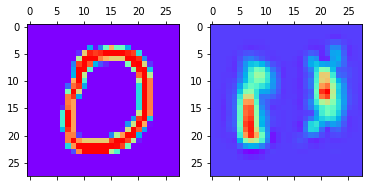

Predicted: 6


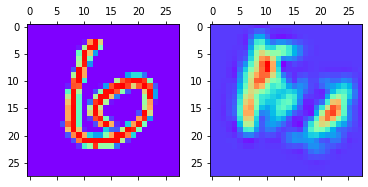

Predicted: 9


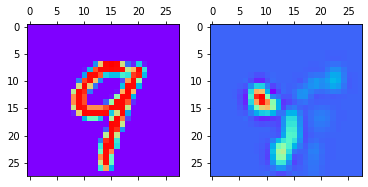

Predicted: 0


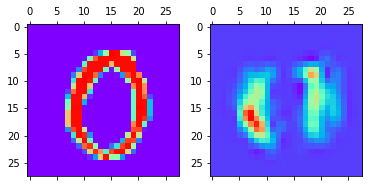

Predicted: 1


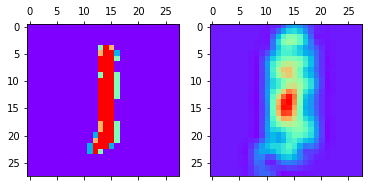

Predicted: 5


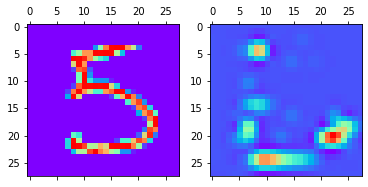

Predicted: 9


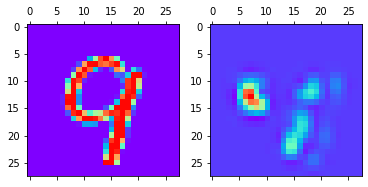

Predicted: 7


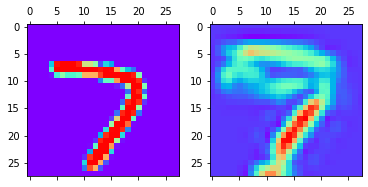

Predicted: 3


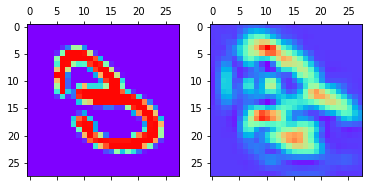

Predicted: 4


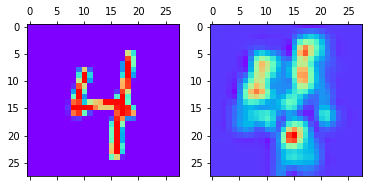

In [41]:
for i in range(20):
  img_array = x_test[i]

  # Print what the top predicted class is
  preds = model.predict(img_array[None,:,:])
  print("Predicted:", np.argmax(preds))

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array[None,:,:], model, model.layers[2].name, pred_index=y_test[i])
  big_heatmap = cv2.resize(heatmap, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)

  # Display heatmap
  fig, (ax1, ax2) = plt.subplots(1,2)
  ax1.matshow(img_array, cmap='rainbow')
  ax2.matshow(big_heatmap, cmap='rainbow')
  plt.show()

## Custom training loop

In [42]:
input_shape = (28, 28, 1)

model2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu', input_shape=input_shape),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'), # conv2d_3
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10),
])

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 3136)              0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [43]:
from tensorflow import keras
from tensorflow.keras import layers

model2.compile()

# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.Adam()
# Instantiate a loss function.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = tf.keras.metrics.Accuracy()
val_acc_metric = tf.keras.metrics.Accuracy()

In [44]:
# Reserve 10,000 samples for validation.
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [45]:
batch_size = 64

epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model2(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))


Start of epoch 0


ValueError: No gradients provided for any variable: (['conv2d_8/kernel:0', 'conv2d_8/bias:0', 'conv2d_9/kernel:0', 'conv2d_9/bias:0', 'dense_8/kernel:0', 'dense_8/bias:0', 'dense_9/kernel:0', 'dense_9/bias:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'conv2d_8/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
array([[[[ 0.12301867, -0.114402  , -0.03741156, -0.02997365,
          -0.34060588,  0.08083561,  0.290893  ,  0.1418857 ,
           0.21560663, -0.36283663, -0.00219742,  0.06122159,
           0.10346636, -0.26967415,  0.40929043, -0.25452793,
           0.04084517,  0.09867572,  0.10370374, -0.01942996,
           0.20066155,  0.00713449,  0.06024176, -0.10995029,
           0.16216992, -0.11017298, -0.3288968 ,  0.20875695,
          -0.17760967,  0.10890367, -0.16935335, -0.33915532]],

        [[-0.07962603,  0.05488422,  0.13905512,  0.03245195,
          -0.60921305, -0.07685458, -0.02668296,  0.20561357,
           0.20816979, -0.39137274,  0.02230645,  0.16694467,
           0.05980124,  0.11134333,  0.2178056 ,  0.04379632,
           0.11372218,  0.227421  ,  0.07973161, -0.03482284,
           0.07819172,  0.11542079,  0.02956142,  0.15356658,
           0.06074271, -0.53407735,  0.03668934, -0.3091091 ,
           0.2637974 , -0.07937367, -0.41680092, -0.21677047]],

        [[-0.3873168 , -0.15109521,  0.00383018,  0.07917033,
          -0.26610672, -0.2619799 , -0.24279484,  0.00512749,
           0.09578487,  0.019519  ,  0.08599146,  0.3896632 ,
          -0.44390884,  0.0746703 ,  0.13240875,  0.17782101,
          -0.11242103, -0.03440667, -0.08738442,  0.13615029,
           0.28322443, -0.1833262 ,  0.00519894,  0.1954265 ,
           0.272038  , -0.23398857, -0.02199577, -0.4020958 ,
          -0.16995719, -0.02194244, -0.11361716,  0.22251987]]],


       [[[ 0.39176312,  0.06869282, -0.04700303,  0.08485745,
          -0.20712687,  0.03078263,  0.19673519,  0.22726682,
          -0.40031248, -0.53961015, -0.0828286 , -0.19382907,
           0.06883957, -0.45307055, -0.01798042, -0.08616205,
           0.04503335, -0.17039083, -0.11759595,  0.02676019,
           0.05646528, -0.39583912, -0.16021274, -0.24770138,
          -0.11233904,  0.46702263,  0.09002246, -0.02528885,
          -0.08154316, -0.02001513, -0.17013358, -0.4192551 ]],

        [[ 0.01934085, -0.15380046, -0.10101377, -0.1385115 ,
           0.08145339,  0.2872188 , -0.06998338,  0.00130437,
          -0.38796097,  0.12241495,  0.02126231, -0.07127117,
           0.3044844 ,  0.19012147,  0.02010966,  0.38332844,
           0.14367583, -0.00426882,  0.05089235,  0.3075574 ,
           0.05564121, -0.44683126, -0.04805771, -0.57663244,
           0.04754981,  0.14099124,  0.25788224, -0.26157632,
           0.13399722,  0.22688985,  0.23611242,  0.2564094 ]],

        [[-0.34474045,  0.13333875,  0.11458348,  0.04252035,
           0.02613475,  0.25939906, -0.35831824, -0.09437628,
          -0.17620304,  0.09661456, -0.01752995,  0.30411896,
          -0.04671664,  0.37875557, -0.03213605, -0.10542887,
          -0.29469323,  0.13333423, -0.02478528, -0.07448722,
          -0.06016113, -0.31163612,  0.02953476, -0.21017933,
          -0.00822707, -0.15789135, -0.01443751,  0.09883312,
          -0.09414156,  0.16494928,  0.28673652,  0.29388857]]],


       [[[ 0.11795855,  0.09770217, -0.0039024 , -0.02330051,
           0.14373444, -0.21828665,  0.270331  , -0.18177254,
           0.18480957, -0.23648636, -0.07211551, -0.35240853,
          -0.23706596, -0.4364655 , -0.33663437,  0.12273999,
           0.15690279, -0.04513538, -0.08065683,  0.05248521,
          -0.20948312,  0.15709469,  0.0359819 ,  0.46004975,
          -0.261508  , -0.00869466, -0.06020333,  0.21880959,
           0.06119521, -0.16257444,  0.268125  ,  0.02175829]],

        [[ 0.15327182,  0.01669625,  0.15303586,  0.04197078,
           0.2925186 , -0.10545702, -0.04150232, -0.1866653 ,
           0.07703368,  0.07094551,  0.02164382, -0.43765134,
           0.24312648, -0.10484705, -0.22424562,  0.14441253,
           0.19010606,  0.02591154,  0.11446442, -0.08727609,
          -0.12413627,  0.02335763,  0.07174101,  0.16899432,
          -0.34060392,  0.3023864 , -0.02147659,  0.23356654,
           0.11213926, -0.1116223 ,  0.19299343,  0.10314681]],

        [[-0.03463332, -0.01611913, -0.01467788, -0.00327715,
           0.25576738, -0.01255074, -0.20630234, -0.30700693,
          -0.04757294,  0.35059157, -0.08801027, -0.04937004,
           0.11794551,  0.21817325, -0.02690986, -0.46978584,
          -0.10823029,  0.17781642,  0.03103831, -0.35961857,
          -0.35164532, -0.2603299 , -0.02113142, -0.02044301,
          -0.15534629,  0.01235871, -0.3343922 ,  0.26533347,
          -0.18632577,  0.12435408, -0.04951875, -0.08520702]]]],
      dtype=float32)>), (None, <tf.Variable 'conv2d_8/bias:0' shape=(32,) dtype=float32, numpy=
array([-0.03513053, -0.18986863, -0.22147381, -0.21051383,  0.09080527,
       -0.16819791, -0.01996937, -0.06443118, -0.02754478, -0.00512573,
       -0.14196712, -0.02119128, -0.23943621, -0.02181929,  0.02142468,
       -0.09482031, -0.12904665, -0.21910608, -0.262678  , -0.0910491 ,
        0.00330118,  0.23508082, -0.1735516 ,  0.00438299, -0.00265024,
       -0.01963755, -0.05234703, -0.07910157, -0.07876206, -0.20340155,
       -0.01206397, -0.0655928 ], dtype=float32)>), (None, <tf.Variable 'conv2d_9/kernel:0' shape=(3, 3, 32, 64) dtype=float32, numpy=
array([[[[-0.15164302, -0.14278013, -0.1544489 , ...,  0.13283896,
          -0.15098609,  0.1788594 ],
         [-0.06181099,  0.04697648,  0.07111503, ...,  0.03184389,
          -0.04203865, -0.1557095 ],
         [ 0.06904306, -0.0019441 ,  0.07751734, ..., -0.05682277,
          -0.1747425 , -0.06881467],
         ...,
         [ 0.04903901,  0.01674099,  0.04153766, ..., -0.14274497,
          -0.18960352,  0.13337019],
         [-0.06637845,  0.11737332, -0.06162178, ..., -0.18871462,
          -0.13617383, -0.11850967],
         [ 0.05709165,  0.10996541, -0.08048937, ..., -0.3056643 ,
          -0.2654198 , -0.22303061]],

        [[ 0.03457435, -0.06696453, -0.11539357, ..., -0.04636769,
          -0.29061863,  0.08026097],
         [ 0.05892342,  0.09228497, -0.04719073, ..., -0.16537687,
           0.0526581 , -0.24448912],
         [ 0.01925246,  0.11431312, -0.00937068, ..., -0.22355694,
           0.03487893, -0.0901066 ],
         ...,
         [ 0.12743522,  0.06574525,  0.0282633 , ..., -0.14361244,
          -0.04878512, -0.07454559],
         [ 0.00761216,  0.12166478, -0.28989547, ..., -0.27612445,
           0.11834198, -0.24469589],
         [ 0.09140523,  0.08776324, -0.38967016, ..., -0.12011165,
           0.02099097, -0.08182806]],

        [[ 0.03693765,  0.03944921, -0.17534347, ..., -0.15694304,
           0.04883949,  0.0269737 ],
         [ 0.0422554 ,  0.0712528 , -0.03163647, ...,  0.19497114,
          -0.05575171,  0.13779853],
         [-0.13740014, -0.00941253, -0.0517365 , ...,  0.18319179,
           0.02266271,  0.17841615],
         ...,
         [ 0.15001893,  0.03558747,  0.07358079, ...,  0.11272765,
          -0.1708335 ,  0.0368252 ],
         [-0.12031158, -0.27222478, -0.3265621 , ...,  0.15049174,
           0.11525766,  0.13895054],
         [-0.37047824, -0.1255797 , -0.3564104 , ...,  0.2931347 ,
           0.11541008,  0.36622053]]],


       [[[-0.3866306 , -0.02286351, -0.45910588, ...,  0.31543702,
          -0.24182257, -0.10248248],
         [-0.06758094,  0.02448956, -0.08960027, ...,  0.07508054,
          -0.10121404, -0.15880816],
         [ 0.10638474,  0.02220597, -0.07607738, ..., -0.01613037,
          -0.14342873, -0.18329659],
         ...,
         [-0.06592871, -0.07411666,  0.11495619, ...,  0.0036529 ,
          -0.11122473, -0.06191416],
         [-0.08983187,  0.10353284, -0.48715913, ...,  0.00442883,
          -0.00432689,  0.222167  ],
         [-0.08940749,  0.13782002, -0.10126363, ..., -0.06056896,
          -0.08631349, -0.40658915]],

        [[-0.5896592 , -0.00996026, -0.03833866, ...,  0.11288226,
           0.0394105 , -0.16230889],
         [-0.11819088, -0.0831778 ,  0.03666841, ..., -0.15424791,
          -0.08630664, -0.31701168],
         [ 0.0153288 ,  0.06520202,  0.03967364, ..., -0.0193044 ,
          -0.05803489, -0.27245376],
         ...,
         [-0.0574576 , -0.01036914, -0.01498332, ..., -0.05772941,
          -0.11669993,  0.01347252],
         [-0.00875684, -0.3845006 , -0.17204282, ..., -0.23092224,
           0.16517484, -0.37213394],
         [-0.08373012,  0.1499052 , -0.12878151, ..., -0.05414287,
           0.23572114, -0.21376868]],

        [[-0.06200833,  0.15422694,  0.16206929, ..., -0.22787526,
           0.11453883, -0.19537285],
         [ 0.01221778, -0.10703598,  0.02044141, ...,  0.08875422,
          -0.12962247, -0.01606939],
         [ 0.11521597, -0.2199744 , -0.05961062, ...,  0.01171661,
          -0.20518349,  0.14264795],
         ...,
         [-0.15048164, -0.04762669, -0.13593845, ...,  0.18875496,
          -0.31873542,  0.05498895],
         [ 0.05919307, -0.6404023 , -0.08428494, ..., -0.13625479,
          -0.08810855, -0.09357867],
         [ 0.13194352, -0.31613293, -0.17074071, ...,  0.17608954,
          -0.10280318,  0.27498916]]],


       [[[-0.4052281 , -0.15624553, -0.47714993, ...,  0.15723166,
          -0.10428911,  0.20906006],
         [-0.03340845, -0.13436697, -0.09065089, ...,  0.10381955,
          -0.03713393,  0.11829492],
         [ 0.04814366, -0.19207373,  0.00739177, ..., -0.03664241,
           0.0018909 ,  0.14590839],
         ...,
         [-0.09247702,  0.02779707,  0.23172504, ..., -0.00108453,
           0.01206255,  0.07825626],
         [ 0.21983616, -0.6802147 , -0.17364085, ...,  0.07389621,
          -0.08374511,  0.30275974],
         [ 0.06909532, -0.31538454,  0.00135179, ..., -0.04717696,
           0.10348159, -0.03537766]],

        [[-0.35551843, -0.12870981,  0.22897972, ...,  0.11797038,
           0.18189782,  0.17641918],
         [ 0.04957955, -0.16510487, -0.04808109, ..., -0.15938812,
          -0.07462277, -0.02654193],
         [ 0.03360326, -0.12648001,  0.05082309, ..., -0.04638241,
          -0.11893622, -0.119485  ],
         ...,
         [ 0.06066598, -0.20740226,  0.04442225, ..., -0.07167181,
          -0.19543527, -0.25877884],
         [ 0.3350588 , -0.36931205,  0.11201781, ..., -0.11649754,
           0.06522205,  0.04437577],
         [ 0.24919972, -0.27522   ,  0.10103081, ..., -0.19157487,
           0.06801068, -0.30423763]],

        [[-0.21807133, -0.02651048,  0.18719417, ..., -0.0791471 ,
          -0.05429556, -0.08815878],
         [ 0.131436  , -0.14763251, -0.14523527, ..., -0.03731013,
          -0.07611125, -0.11100671],
         [ 0.06561463, -0.16376737, -0.3051174 , ...,  0.00731053,
          -0.3385816 , -0.28661305],
         ...,
         [ 0.01516129, -0.15140553, -0.33437115, ...,  0.05380436,
          -0.30438536, -0.24514873],
         [ 0.22182976, -0.11215518, -0.2766526 , ..., -0.10224735,
           0.11786608, -0.20468892],
         [ 0.23233683,  0.06737812, -0.49195614, ...,  0.11179876,
          -0.14043722, -0.36521465]]]], dtype=float32)>), (None, <tf.Variable 'conv2d_9/bias:0' shape=(64,) dtype=float32, numpy=
array([-0.1930867 , -0.0643224 ,  0.00620185, -0.03032363, -0.14665431,
       -0.14942206, -0.10306466, -0.08873505,  0.01503106, -0.12369521,
       -0.11919042, -0.01847744, -0.05345804, -0.07103562, -0.0540835 ,
       -0.04275995, -0.06803689, -0.13498475, -0.02039388, -0.1560574 ,
       -0.10768732,  0.00385845, -0.10325699, -0.09193772, -0.02078656,
       -0.17054643, -0.18950492, -0.05600342, -0.11147694, -0.16174488,
        0.01345515, -0.05107022, -0.03776551, -0.0484843 , -0.12287275,
       -0.12629688, -0.12100777, -0.07925769, -0.17438799, -0.14086336,
       -0.0836461 , -0.03379496, -0.06658319, -0.02399168, -0.06953711,
       -0.0822971 , -0.03320351, -0.07512969, -0.06661244, -0.12277107,
       -0.00099844, -0.11421506, -0.07666097, -0.09806392, -0.10956372,
       -0.15595499,  0.00643256, -0.05738353,  0.03922969, -0.08309528,
       -0.14510596, -0.10142386, -0.07331429, -0.10649365], dtype=float32)>), (None, <tf.Variable 'dense_8/kernel:0' shape=(3136, 64) dtype=float32, numpy=
array([[ 0.02488512, -0.01647411,  0.0240721 , ..., -0.02575291,
        -0.02862548,  0.03539869],
       [ 0.0038903 , -0.17913434,  0.02176342, ..., -0.01392732,
         0.02453725,  0.01845685],
       [-0.03105223,  0.02441732, -0.03109222, ...,  0.00503072,
        -0.019442  ,  0.04895959],
       ...,
       [ 0.13813233, -0.02782208,  0.01769591, ..., -0.09719234,
        -0.01176742,  0.01980649],
       [-0.11561545,  0.02698484,  0.03838448, ..., -0.08691663,
         0.03713438, -0.07712571],
       [ 0.09015319, -0.10606699, -0.00780964, ...,  0.03782628,
         0.00252821,  0.11424877]], dtype=float32)>), (None, <tf.Variable 'dense_8/bias:0' shape=(64,) dtype=float32, numpy=
array([ 0.01795859,  0.0269479 , -0.00686023, -0.05500789,  0.04165787,
       -0.03105083, -0.01053913, -0.0405758 , -0.07235912, -0.00656151,
       -0.06541521, -0.01519095, -0.01083914,  0.03907973, -0.0074723 ,
        0.01306555,  0.01460602,  0.02157953,  0.02357876, -0.02115825,
        0.04752967, -0.0237749 ,  0.0255532 ,  0.02499787, -0.04373705,
       -0.00994678,  0.04403469, -0.03895117, -0.01174814, -0.00072323,
        0.04974939,  0.02697578, -0.03235382, -0.01038517, -0.0092957 ,
       -0.08330819, -0.03214759,  0.0426757 ,  0.02263625, -0.06617589,
       -0.06646752, -0.00984759,  0.04646407,  0.02838292,  0.02093573,
       -0.05888602, -0.01327646, -0.00600492,  0.0090089 ,  0.00557945,
       -0.03033884, -0.00049726, -0.00758549, -0.01738095,  0.05492279,
        0.05356633,  0.01412151, -0.00600424, -0.04756872, -0.01174355,
       -0.03083349, -0.05033477, -0.0060578 ,  0.04638805], dtype=float32)>), (None, <tf.Variable 'dense_9/kernel:0' shape=(64, 10) dtype=float32, numpy=
array([[ 1.89242199e-01, -1.38161153e-01, -4.51919317e-01,
        -8.77334625e-02,  2.34008610e-01, -4.49091196e-01,
        -1.35092542e-01,  3.46012622e-01,  1.12885050e-01,
         2.35082000e-01],
       [-2.75848478e-01,  2.01218009e-01,  1.24179564e-01,
         9.28204209e-02,  4.18075249e-02, -4.19020385e-01,
         1.07729524e-01,  3.30348730e-01, -1.14831574e-01,
        -2.77798057e-01],
       [ 1.52234286e-01, -1.30409107e-01, -2.89303035e-01,
        -2.65530169e-01, -1.08579002e-01,  2.85405312e-02,
        -1.36585966e-01, -2.75016993e-01, -8.15018117e-02,
         1.05481325e-02],
       [-5.61568290e-02, -4.63618964e-01, -2.11345047e-01,
         1.50101662e-01,  1.27883539e-01,  2.25601554e-01,
         3.43923837e-01,  1.43479910e-02, -1.08391000e-02,
         1.57364145e-01],
       [-7.89927393e-02,  2.18465284e-01, -6.20665438e-02,
        -5.99575996e-01, -1.88960552e-01, -4.61915940e-01,
         4.11527038e-01, -4.46017832e-01, -2.48502135e-01,
         6.45150244e-02],
       [ 8.80254135e-02,  2.82064807e-02,  7.98067227e-02,
         2.62219995e-01, -1.54946940e-02, -3.67316902e-01,
        -2.45667607e-01,  9.45299715e-02, -2.97936767e-01,
        -4.92161363e-02],
       [-2.08195254e-01,  1.04631849e-01, -4.40120846e-02,
         2.32551083e-01,  2.56028056e-01, -2.42278904e-01,
        -1.62702147e-02, -1.25239566e-01,  7.65262470e-02,
         1.84543252e-01],
       [-1.00234106e-01, -1.31355405e-01,  1.45695671e-01,
         2.00982660e-01, -1.42214932e-02,  2.12407321e-01,
        -4.75273907e-01,  2.67743796e-01,  1.14457108e-01,
         7.81080350e-02],
       [-4.39238548e-01, -2.79376566e-01,  1.65353455e-02,
         2.97191203e-01, -1.23860992e-01,  9.36370715e-02,
         1.58008501e-01,  1.06014058e-01, -7.14834407e-02,
         5.70775196e-02],
       [ 3.94143397e-03,  2.76612252e-01, -2.03165665e-01,
         5.25887683e-03,  1.65668115e-01, -1.40719771e-01,
         3.15667242e-02, -2.79456109e-01,  2.68866658e-01,
         1.70833960e-01],
       [ 4.52426672e-02, -3.60532433e-01,  3.48341048e-01,
         8.08829889e-02,  1.10287935e-01, -1.71337798e-01,
         1.19721465e-01, -2.76514262e-01,  1.86469615e-01,
         8.01245645e-02],
       [-9.44954529e-02,  2.65728176e-01, -1.40088484e-01,
        -1.46727756e-01,  1.83518499e-01, -2.14242220e-01,
         1.25063211e-01,  2.22377881e-01,  3.41425166e-02,
         1.77762613e-01],
       [-3.60668689e-01, -2.58766800e-01, -1.23027503e-01,
         3.07998091e-01,  2.69278526e-01,  1.32431492e-01,
        -1.47495710e-03, -2.21788846e-02,  2.83992201e-01,
        -2.85218716e-01],
       [ 1.92986935e-01,  2.14547947e-01,  2.41453469e-01,
        -5.25280118e-01,  2.80732125e-01, -2.22549289e-01,
        -1.92197025e-01, -2.73482680e-01,  1.72924742e-01,
         2.81312913e-01],
       [-2.07292177e-02, -2.42696926e-01,  2.36575678e-01,
        -1.77435670e-02,  5.92196658e-02, -2.06011832e-01,
         1.14803500e-01, -3.96947227e-02,  1.84015304e-01,
        -1.61510110e-02],
       [ 1.56660855e-01, -7.47395009e-02, -8.85607209e-03,
         2.09166184e-02, -4.46873516e-01,  4.70253900e-02,
        -6.99098483e-02,  4.94732012e-05, -3.27894956e-01,
        -4.22250956e-01],
       [ 2.40292639e-01, -2.51344353e-01, -2.30567709e-01,
        -3.60279232e-01,  1.25781864e-01,  9.21856314e-02,
        -1.22427531e-01,  1.96741130e-02,  4.71515618e-02,
         2.18665555e-01],
       [ 3.87428552e-01,  8.80258679e-02,  2.80736119e-01,
        -4.54512835e-02, -5.42309761e-01,  7.61168972e-02,
         8.25216770e-02, -1.82565108e-01,  1.18127596e-02,
         3.66449058e-02],
       [-1.20696135e-01,  2.19323501e-01, -4.74103689e-01,
        -3.81770939e-01,  9.59304571e-02,  2.33716026e-01,
         1.32540762e-01,  3.99864241e-02, -2.94396669e-01,
        -6.14091717e-02],
       [-8.95561557e-03,  3.28511484e-02, -1.54929221e-01,
         1.99767798e-01, -4.84096438e-01,  2.18904063e-01,
        -5.97989596e-02, -4.03382421e-01,  2.55336285e-01,
         5.74204214e-02],
       [-1.02556311e-01,  2.83380955e-01,  1.43499672e-01,
         3.94448899e-02,  6.25595748e-02, -2.83237785e-01,
        -4.69262868e-01,  2.69316345e-01,  6.10518865e-02,
        -1.42963696e-02],
       [-4.95274290e-02, -1.28360808e-01,  1.58174887e-01,
         1.49255753e-01,  2.06701279e-01,  2.54459649e-01,
        -2.52381921e-01,  2.32981592e-01, -3.36276144e-01,
        -1.12446263e-01],
       [-7.24513009e-02, -6.64933175e-02, -8.21945295e-02,
        -1.95642427e-01, -5.45782506e-01,  2.56405681e-01,
         2.57824473e-02, -4.16516066e-01, -1.57409042e-01,
        -1.50807321e-01],
       [-5.55746034e-02,  2.39844710e-01,  1.97909087e-01,
         3.02390426e-01, -3.88285041e-01, -1.89373326e-02,
         6.13682270e-02, -1.77548289e-01, -3.21024567e-01,
        -2.32609227e-01],
       [-6.12107754e-01, -1.28000990e-01, -1.53440982e-01,
        -5.51456988e-01,  2.33664721e-01,  2.82882005e-01,
        -5.15377745e-02, -2.35975593e-01, -2.70205662e-02,
         1.89804316e-01],
       [-1.60550684e-01, -8.89222473e-02, -2.54735220e-02,
        -2.53625900e-01,  2.08240241e-01,  1.30869880e-01,
         1.55764863e-01,  2.21799493e-01, -1.09517179e-01,
         2.19312176e-01],
       [-4.24692690e-01,  3.23889047e-01, -4.98771220e-01,
        -1.97853208e-01,  1.99479669e-01, -4.46144015e-01,
        -3.51707369e-01,  2.95248866e-01,  8.83806273e-02,
         1.16451904e-01],
       [ 6.71864524e-02,  9.67477337e-02, -7.26198629e-02,
        -1.61934067e-02,  8.61208290e-02, -9.97688100e-02,
         7.77761713e-02, -4.27748263e-02, -1.09477090e-02,
        -1.55789673e-01],
       [-2.72028565e-01,  1.69237524e-01, -2.78641224e-01,
        -1.81719169e-01, -1.04437739e-01,  1.57886654e-01,
         1.57081371e-03, -1.90111846e-01, -1.34446293e-01,
        -2.17191845e-01],
       [-1.83342725e-01,  1.70700520e-01, -9.46497992e-02,
         9.77289081e-02,  2.16207102e-01, -1.66837782e-01,
        -6.44856572e-01,  3.29870045e-01, -5.96145838e-02,
         2.55079925e-01],
       [ 2.80406624e-01,  2.36943886e-01, -5.33811808e-01,
         8.22708905e-02, -4.38450098e-01, -2.61627585e-02,
        -2.20086798e-01,  7.46591240e-02,  2.00548664e-01,
        -3.55359465e-02],
       [ 3.29238892e-01,  1.67220175e-01,  2.68509328e-01,
         8.92354362e-03, -4.87479895e-01,  1.83499679e-01,
        -2.23821234e-02,  2.35851273e-01,  2.24674717e-01,
        -2.87812650e-01],
       [-1.01537757e-01, -1.37888849e-01,  8.25367775e-03,
        -9.75805297e-02,  5.36829792e-02,  2.94773132e-01,
         6.45548925e-02,  3.29304487e-02,  2.03461230e-01,
        -6.49045110e-02],
       [-3.89445126e-01, -2.80991465e-01,  2.17919409e-01,
        -9.02787298e-02,  6.85129538e-02, -1.27324626e-01,
        -8.85140300e-02, -1.25001982e-01, -6.60604378e-03,
        -5.12810171e-01],
       [-1.17764279e-01,  4.39042337e-02, -2.45654479e-01,
         2.24007353e-01, -1.33994251e-01, -7.92010128e-02,
        -2.25643720e-03, -7.93139562e-02, -4.52664010e-02,
        -7.03570396e-02],
       [-2.33861282e-01, -2.07173064e-01, -1.01474732e-01,
        -2.24444240e-01, -5.58207184e-02, -1.67499222e-02,
        -1.02919787e-01,  4.67651188e-02, -6.29837140e-02,
         7.76813328e-02],
       [ 5.09527214e-02, -1.64917812e-01,  2.32006401e-01,
         1.31001994e-01, -2.36404106e-01, -9.17287096e-02,
        -4.86208171e-01,  6.95434958e-02, -7.97056779e-02,
        -4.21319515e-01],
       [-1.28471568e-01,  2.89534599e-01,  1.09060384e-01,
        -1.64890945e-01,  1.39023036e-01,  3.22481334e-01,
        -2.82199413e-01, -7.66053749e-03, -6.23120777e-02,
        -3.61029297e-01],
       [ 2.79567331e-01, -4.38187152e-01, -2.07272060e-02,
        -1.70534223e-01,  4.20179129e-01,  2.11338904e-02,
         2.40432635e-01, -3.10730606e-01, -5.50534189e-01,
         1.05975293e-01],
       [-3.73770565e-01, -2.17158064e-01, -7.00216144e-02,
         3.21052164e-01, -3.87327164e-01,  1.31161854e-01,
         6.93934336e-02,  1.86159778e-02, -2.66764790e-01,
         1.48938268e-01],
       [-4.62652057e-01, -4.33390170e-01, -5.39963365e-01,
         2.35111371e-01,  2.19996929e-01,  2.85454206e-02,
        -3.50033045e-01, -2.69353151e-01,  3.48728970e-02,
         1.62703842e-01],
       [ 7.41622597e-02, -2.67204583e-01, -1.46548226e-01,
         5.54015450e-02,  5.15123233e-02, -2.31765702e-01,
         9.17571932e-02,  1.95148110e-01, -1.94546789e-01,
         6.10568784e-02],
       [ 2.49925554e-01,  3.21268402e-02, -1.79414943e-01,
        -1.27909437e-01, -1.50282979e-01, -1.91943929e-01,
         7.88328946e-02, -3.17982376e-01,  1.41841667e-02,
         2.22986400e-01],
       [-1.81398526e-01, -4.20335606e-02,  1.87411621e-01,
        -4.08266604e-01,  5.20192902e-04, -9.42426398e-02,
         3.33061188e-01, -1.85102388e-01,  2.66572982e-01,
        -3.61261100e-01],
       [-3.36810827e-01,  1.60380125e-01,  2.49795839e-01,
         3.31211358e-01, -4.96170036e-02, -3.63162011e-01,
        -6.31902516e-02, -1.58805624e-01, -2.13921934e-01,
         5.95794469e-02],
       [ 1.10538393e-01,  1.62778422e-01, -2.05839500e-01,
        -1.97232962e-01,  2.33872339e-01, -9.52067599e-03,
        -2.17291936e-02, -2.56734639e-02,  9.37802121e-02,
        -2.61755168e-01],
       [-2.78708577e-01,  9.03441980e-02,  1.74227908e-01,
        -2.15673685e-01, -2.35427216e-01,  1.96386129e-03,
         1.92325786e-01,  2.58528978e-01,  2.72753779e-02,
         5.48671000e-02],
       [-2.28710234e-01,  8.47996920e-02, -1.24170654e-01,
        -1.82718337e-01,  1.21440619e-01, -2.59740949e-01,
        -1.06872067e-01,  9.32479575e-02, -2.71718085e-01,
        -9.68089178e-02],
       [-2.94152826e-01,  7.61989430e-02, -2.44833380e-01,
        -1.62227452e-02,  7.97466487e-02,  2.35280544e-01,
         6.09260537e-02, -2.28225559e-01,  3.37840080e-01,
        -3.47361118e-01],
       [ 2.73208320e-01, -3.64366174e-01, -3.09415311e-01,
        -1.46240905e-01, -3.77234876e-01, -8.18788819e-03,
         2.09630191e-01,  2.63757259e-01,  3.65002118e-02,
         1.68838739e-01],
       [-3.75917912e-01, -1.31424725e-01,  1.36610925e-01,
        -4.84095812e-02, -3.66163909e-01, -3.55615497e-01,
        -2.80888706e-01,  1.32723078e-01,  3.06543201e-01,
         2.44735405e-01],
       [ 1.52289391e-01, -5.29068649e-01,  3.85260701e-01,
        -3.51876378e-01, -1.60240471e-01, -3.13839972e-01,
         1.14799790e-04, -2.94192415e-02, -2.89046317e-02,
        -2.15089008e-01],
       [ 8.02560970e-02,  2.71740198e-01, -1.11629419e-01,
        -1.41458899e-01, -1.53803840e-01, -6.44672811e-02,
         1.44150201e-02, -3.25316191e-02, -2.38124833e-01,
        -1.17620170e-01],
       [-2.02738270e-01, -3.51590812e-01, -3.68316531e-01,
        -4.62201566e-01, -2.45446816e-01, -4.36213389e-02,
        -4.13830280e-01,  3.25922310e-01, -4.70703632e-01,
         1.73483238e-01],
       [-7.89202899e-02,  9.65999067e-02,  2.48201951e-01,
        -1.53939977e-01,  9.91500765e-02, -1.42269641e-01,
         3.25584561e-02, -1.71405524e-01,  1.83695495e-01,
        -3.30326498e-01],
       [-4.87806275e-02,  1.00387707e-01,  9.90309939e-03,
        -4.86639351e-01,  2.59851754e-01, -2.69609302e-01,
         2.81430990e-01,  3.07603747e-01, -5.20437717e-01,
         3.27657685e-02],
       [ 3.41538846e-01, -4.54816580e-01, -3.23946476e-01,
         2.34677389e-01, -2.05343604e-01, -1.81649491e-01,
         5.72021268e-02, -5.69773912e-01,  2.61343509e-01,
        -1.04667611e-01],
       [ 1.70332715e-02,  1.41304970e-01,  4.80485521e-02,
        -4.66306619e-02,  2.12391332e-01,  1.71044320e-01,
         7.64211342e-02, -1.89617515e-01,  2.74527699e-01,
         2.16206983e-01],
       [-1.39975786e-01, -4.37436640e-01, -4.16703165e-01,
        -1.59849286e-01,  2.02631846e-01, -1.20412886e-01,
        -3.52676272e-01,  3.25952433e-02,  5.10254502e-01,
        -2.97495816e-02],
       [-2.35646769e-01, -3.48756522e-01,  2.78169215e-01,
        -1.75133914e-01, -1.44669432e-02,  1.24634117e-01,
        -3.85923952e-01,  5.70708774e-02, -8.30969363e-02,
         2.26417571e-01],
       [ 1.10917240e-01,  2.36834288e-01, -2.42924884e-01,
        -3.93669531e-02,  1.54860437e-01, -1.11640066e-01,
        -1.98650122e-01, -3.41172591e-02,  2.62691319e-01,
        -1.78700864e-01],
       [-2.25465879e-01,  1.71614677e-01,  1.48118094e-01,
        -7.43668526e-02, -2.28985339e-01,  2.02826008e-01,
         5.40693030e-02, -1.16632134e-01, -2.32406214e-01,
         1.39300063e-01],
       [ 2.16866046e-01,  2.60150254e-01, -2.43927255e-01,
         7.49154240e-02, -5.06392121e-02, -4.45588268e-02,
         7.44469389e-02, -1.91996038e-01,  2.18411833e-01,
         2.49651611e-01],
       [-1.56312823e-01,  2.35415503e-01, -3.16577733e-01,
        -2.43091751e-02,  3.50651532e-01, -2.95681655e-01,
        -3.95310163e-01, -4.21367258e-01, -2.36681908e-01,
         2.75972575e-01]], dtype=float32)>), (None, <tf.Variable 'dense_9/bias:0' shape=(10,) dtype=float32, numpy=
array([ 0.0881462 ,  0.10943189,  0.00377507, -0.05145144, -0.04418104,
        0.00119571, -0.03971283, -0.02093424,  0.00955123, -0.04126815],
      dtype=float32)>)).